In [23]:
import sys
import os
from tensorflow.keras.models import load_model
import joblib
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt


module_path = os.path.abspath(os.path.join('..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from functions import add_growth_score_based_on_main_features, add_repo_age_days_col, add_days_since_last_release_col, convert_topics_to_embeddings, indexify_release_dates, add_lag_features_based_on_target, scale_final_data, remove_outliers, reduce_dimentionality_pca, forecast_growth, get_single_repo_data, remove_unwanted_features, distribute_features_across_releases, apply_time_based_noise, apply_proportional_noise, remove_first_augmented_rows
import numpy as np

root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_dir)
from config import GITHUB_TOKEN



In [24]:
# https://github.com/tensorflow/tensorflow
# https://github.com/vim-airline/vim-airline
test_df = get_single_repo_data('https://github.com/tensorflow/tensorflow', GITHUB_TOKEN)

test_df.head(20)

,org_name,repo_name,description,repo_url,topics,creation_date,update_date,release_tag,release_date,num_releases,num_open_issues,num_pull_requests,num_stars,num_forks,num_watchers
0,tensorflow,tensorflow,An Open Source Machine Learning Framework for ...,https://github.com/tensorflow/tensorflow,"tensorflow, machine-learning, python, deep-lea...",2015-11-07T01:19:20Z,2024-09-27T02:26:38Z,v2.17.0,2024-07-11T16:28:57Z,30,4919,36102,185745,74211,185745
1,tensorflow,tensorflow,An Open Source Machine Learning Framework for ...,https://github.com/tensorflow/tensorflow,"tensorflow, machine-learning, python, deep-lea...",2015-11-07T01:19:20Z,2024-09-27T02:26:38Z,v2.17.0-rc1,2024-07-02T04:17:28Z,30,4919,36102,185745,74211,185745
2,tensorflow,tensorflow,An Open Source Machine Learning Framework for ...,https://github.com/tensorflow/tensorflow,"tensorflow, machine-learning, python, deep-lea...",2015-11-07T01:19:20Z,2024-09-27T02:26:38Z,v2.16.2,2024-06-28T18:56:30Z,30,4919,36102,185745,74211,185745
3,tensorflow,tensorflow,An Open Source Machine Learning Framework for ...,https://github.com/tensorflow/tensorflow,"tensorflow, machine-learning, python, deep-lea...",2015-11-07T01:19:20Z,2024-09-27T02:26:38Z,v2.17.0-rc0,2024-06-18T20:41:46Z,30,4919,36102,185745,74211,185745
4,tensorflow,tensorflow,An Open Source Machine Learning Framework for ...,https://github.com/tensorflow/tensorflow,"tensorflow, machine-learning, python, deep-lea...",2015-11-07T01:19:20Z,2024-09-27T02:26:38Z,v2.15.1,2024-03-08T19:09:29Z,30,4919,36102,185745,74211,185745
5,tensorflow,tensorflow,An Open Source Machine Learning Framework for ...,https://github.com/tensorflow/tensorflow,"tensorflow, machine-learning, python, deep-lea...",2015-11-07T01:19:20Z,2024-09-27T02:26:38Z,v2.16.1,2024-03-07T18:54:30Z,30,4919,36102,185745,74211,185745
6,tensorflow,tensorflow,An Open Source Machine Learning Framework for ...,https://github.com/tensorflow/tensorflow,"tensorflow, machine-learning, python, deep-lea...",2015-11-07T01:19:20Z,2024-09-27T02:26:38Z,v2.16.0-rc0,2024-02-26T22:54:41Z,30,4919,36102,185745,74211,185745
7,tensorflow,tensorflow,An Open Source Machine Learning Framework for ...,https://github.com/tensorflow/tensorflow,"tensorflow, machine-learning, python, deep-lea...",2015-11-07T01:19:20Z,2024-09-27T02:26:38Z,v2.15.0,2023-11-14T18:46:08Z,30,4919,36102,185745,74211,185745
8,tensorflow,tensorflow,An Open Source Machine Learning Framework for ...,https://github.com/tensorflow/tensorflow,"tensorflow, machine-learning, python, deep-lea...",2015-11-07T01:19:20Z,2024-09-27T02:26:38Z,v2.14.1,2023-11-14T18:42:20Z,30,4919,36102,185745,74211,185745
9,tensorflow,tensorflow,An Open Source Machine Learning Framework for ...,https://github.com/tensorflow/tensorflow,"tensorflow, machine-learning, python, deep-lea...",2015-11-07T01:19:20Z,2024-09-27T02:26:38Z,v2.15.0-rc1,2023-11-03T18:09:42Z,30,4919,36102,185745,74211,185745


In [25]:
if (test_df['num_releases'] <= 5).any():
    # Do something, like returning or filtering the DataFrame
    print('please provide a repos with more than 5 releases')


df_exploded = test_df 
# Ascending order of release date
df_exploded = df_exploded.sort_values(by='release_date', ascending=True).reset_index(drop=True)


#Data Augmentation
# Distribute each column across the release dates
df_augmented = distribute_features_across_releases(df_exploded, ['num_stars', 'num_forks', 'num_watchers', 'num_pull_requests', 'num_open_issues', 'num_releases'])
df_augmented = apply_time_based_noise(df_augmented, ['num_stars', 'num_forks', 'num_watchers', 'num_pull_requests', 'num_open_issues'])
df_augmented = apply_proportional_noise(df_augmented, ['num_stars', 'num_forks', 'num_watchers', 'num_pull_requests', 'num_open_issues'])
df_augmented = remove_first_augmented_rows(df_augmented)
df_augmented = add_growth_score_based_on_main_features(df_augmented, train=False)
actual_growth_score = df_augmented['growth_score']

test_df = df_augmented
test_df = add_repo_age_days_col(test_df)
test_df = add_days_since_last_release_col(test_df)
test_df = convert_topics_to_embeddings(test_df)
test_df = remove_outliers(test_df)
test_df = indexify_release_dates(test_df)

test_df = add_lag_features_based_on_target(test_df, num=5)

print(actual_growth_score)

/Users/charles.hanna/Development/cb-ds-19/data-science-course-final-project/src/functions.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['growth_score'] = scaled_features.sum(axis=1)
/Users/charles.hanna/Development/cb-ds-19/data-science-course-final-project/src/functions.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['creation_date'] = pd.to_datetime(df['creation_date'])
/Users/charles.hanna/Development/cb-ds-19/data-science-course-final-project/src/functions.py:165: SettingWithCopyWarn

0     0.737393
1     1.437441
2     2.162150
3     2.753088
4     3.357823
5     3.789973
6     4.265780
7     4.488219
8     4.608127
9     4.589957
10    4.569639
11    4.410704
12    4.145217
13    3.936957
14    3.764292
15    3.445252
16    3.140925
17    2.833513
18    2.499053
19    2.478198
20    2.297949
21    2.247795
22    2.521092
23    2.571033
24    2.953353
25    3.427792
26    3.894023
27    4.748394
28    5.034468
Name: growth_score, dtype: float64


/Users/charles.hanna/Development/cb-ds-19/data-science-course-final-project/src/functions.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topic_embedding'] = df['topics'].apply(lambda topic: sentence_embeddings_model.encode(topic))


In [31]:
X = remove_unwanted_features(test_df)
print(X.shape)
X_scaled = scale_final_data(X=X.values)
X_scaled_pca = reduce_dimentionality_pca(X_scaled)

# either/or
n_features_pca = X_scaled_pca.shape[1]
n_features = X_scaled.shape[1]

print(X_scaled_pca.shape[1], n_features_pca)
n_timesteps = 6
test_generator = TimeseriesGenerator(X_scaled_pca, np.zeros(len(X_scaled_pca)), length=n_timesteps, batch_size=1)
# test_generator = TimeseriesGenerator(X_scaled, np.zeros(len(X_scaled)), length=n_timesteps, batch_size=1)

model = load_model('../models/best_rnn_model.keras')

print(X_scaled_pca.shape[0])
print(model.summary())

# Use the updated model for prediction
y_pred = model.predict(test_generator)

print(f'predicted: {y_pred}', f' | actual: {actual_growth_score}')


(24, 397)
170 170
24


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 6, 170)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 6, 64)     │     45,312 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 6, 64)     │          0 │ gru_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_2         │ (None, 6, 64)     │          0 │ dropout_4[0][0],  │
│ (Attention)         │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 6, 64)     │          0 │ dropout_4[0][0],  │
│                     │                   │            │ attention_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 6, 64)     │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 64)        │          0 │ layer_normalizat… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      4,160 │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 148,997 (582.02 KB)

 Trainable params: 49,665 (194.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 99,332 (388.02 KB)

None
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
predicted: [[2.0793598]
 [2.0793598]
 [2.0793598]
 [2.0793598]
 [2.0793598]
 [2.0793598]
 [2.0793598]
 [2.0793598]
 [2.0793598]
 [2.0793598]
 [2.0793598]
 [2.0793598]
 [2.0793598]
 [2.0793598]
 [2.0793598]
 [2.0793598]
 [2.0793598]
 [2.0793598]]  | actual: 0     0.737393
1     1.437441
2     2.162150
3     2.753088
4     3.357823
5     3.789973
6     4.265780
7     4.488219
8     4.608127
9     4.589957
10    4.569639
11    4.410704
12    4.145217
13    3.936957
14    3.764292
15    3.445252
16    3.140925
17    2.833513
18    2.499053
19    2.478198
20    2.297949
21    2.247795
22    2.521092
23    2.571033
24    2.953353
25    3.427792
26    3.894023
27    4.748394
28    5.034468
Name: growth_score, dtype: float64


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [27]:
# Use a few sample values from the actual data
sample_data = np.array([[0.3], [0.5], [0.7], [1.0], [1.2]])
scaler_y = joblib.load('../models/final_target_scaler.pkl')
# Scale the sample data using the fitted MinMaxScaler
scaled_data = scaler_y.transform(sample_data)

# Inverse scale the scaled data back to original
inverse_scaled_data = scaler_y.inverse_transform(scaled_data)

# Print to compare original, scaled, and inverse scaled values
print("Original Data:\n", sample_data)
print("Scaled Data:\n", scaled_data)
print("Inverse Scaled Data:\n", inverse_scaled_data)

Original Data:
 [[0.3]
 [0.5]
 [0.7]
 [1. ]
 [1.2]]
Scaled Data:
 [[0.28974655]
 [0.48291092]
 [0.67607529]
 [0.96582185]
 [1.15898621]]
Inverse Scaled Data:
 [[0.3]
 [0.5]
 [0.7]
 [1. ]
 [1.2]]


In [28]:
n_forecast_steps = 12 
scaler_y = joblib.load('../models/final_target_scaler.pkl')
print("Scaler data min:", scaler_y.data_min_)
print("Scaler data max:", scaler_y.data_max_)
print("Scaler feature range:", scaler_y.feature_range)


initial_data = X_scaled_pca[-n_timesteps:]

print(initial_data.shape)
print("Number of features in X_scaled_pca:", X_scaled_pca.shape[1])


# Perform the forecasting
forecasted_values = forecast_growth(
    model=model, 
    initial_data=initial_data, 
    n_steps=n_forecast_steps, 
    scaler=scaler_y, 
    timesteps=n_timesteps,
    n_features=n_features_pca
)

print("Forecasted Growth Scores:", forecasted_values)

Scaler data min: [0.]
Scaler data max: [1.03538764]
Scaler feature range: (0, 1)
(6, 170)
Number of features in X_scaled_pca: 170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Forecasted Growth Scores: [2.1529434 1.8291159 1.8189178 1.8095323 1.8037505 1.7998495 1.7970414
 1.7970414 1.7970414 1.7970414 1.7970414 1.7970414]


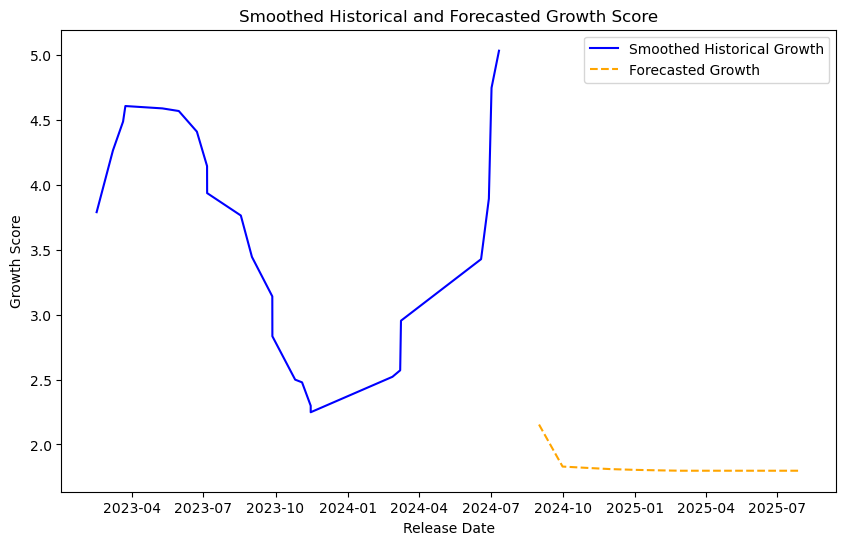

In [29]:
import pandas as pd
# Generate future dates for the forecasted values based on the release_date index
# If you are forecasting 'n_steps' into the future (assuming monthly intervals)
forecasted_dates = pd.date_range(start=test_df.index[-1], periods=n_forecast_steps + 1, freq='M')[1:]

# Plot the smoothed historical growth score and forecasted data
plt.figure(figsize=(10, 6))
plt.plot(test_df.index, test_df['growth_score'], color='blue', label='Smoothed Historical Growth')
plt.plot(forecasted_dates, forecasted_values, color='orange', linestyle='--', label='Forecasted Growth')


plt.xlabel('Release Date')
plt.ylabel('Growth Score')
plt.title('Smoothed Historical and Forecasted Growth Score')
plt.legend()
plt.show()

In [30]:
forecasted_values

array([2.1529434, 1.8291159, 1.8189178, 1.8095323, 1.8037505, 1.7998495,
       1.7970414, 1.7970414, 1.7970414, 1.7970414, 1.7970414, 1.7970414],
      dtype=float32)